In [65]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', None)
from IPython.display import display

from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup

In [47]:
df = pd.read_csv("../data/kershaw.csv")
df['year'] = pd.DatetimeIndex(df['game_date']).year  # separate year from date
df['month'] = pd.DatetimeIndex(df['game_date']).month
df_2008 = df[df['year']==2008]
df_2017_season = df[(df['year']==2017) & (df['month'] >= 4)]

/var/folders/w0/3ttb6cs14rq8l4ggd5r1v9440000gn/T/ipykernel_55066/806051061.py:1: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/kershaw.csv")


In [49]:
states = {(0,0): 0,
          (1,0): 1,
          (2,0): 2,
          (3,0): 3,
          (0,1): 4,
          (0,2): 5,
          (1,1): 6,
          (1,2): 7,
          (2,1): 8,
          (2,2): 9,
          (3,1): 10,
          (3,2): 11,
          "Out": 12, 
          "Single": 13, 
          "Double": 14, 
          "Triple": 15, 
          "HR": 16, 
          "Walk": 17}

In [111]:
unique_games

array(['2017-04-03', '2017-04-08', '2017-04-14', '2017-04-19',
       '2017-04-25', '2017-05-01', '2017-05-06', '2017-05-12',
       '2017-05-17', '2017-05-23', '2017-05-28', '2017-06-02',
       '2017-06-07', '2017-06-13', '2017-06-19', '2017-06-24',
       '2017-06-29', '2017-07-04', '2017-07-09', '2017-07-18',
       '2017-07-23', '2017-09-01', '2017-09-07', '2017-09-12',
       '2017-09-18', '2017-09-24', '2017-09-30', '2017-10-06',
       '2017-10-14', '2017-10-19', '2017-10-24', '2017-10-29',
       '2017-11-01'], dtype=object)

In [117]:
df_simple = df_2017_season.filter(items=['balls',
                             'strikes',
                             'events',
                             'description',
                             'game_date'])
df_simple = df_simple.iloc[::-1] # reverse order from earliest to latest
non_terminal_states = list(zip(df_simple.balls, df_simple.strikes))
df_simple['non_terminal_states'] = non_terminal_states
df_simple = df_simple.reset_index()

#create unique list of names
unique_games = df_simple.game_date.unique()
DataFrameDict = {elem : pd.DataFrame() for elem in unique_games}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df_simple[:][df_simple.game_date == key]

DataFrameDict

{'2017-04-03':     index  balls  strikes     events      description   game_date  \
 0   29771      0        0        NaN    called_strike  2017-04-03   
 1   29770      0        1        NaN             foul  2017-04-03   
 2   29769      0        2        NaN             ball  2017-04-03   
 3   29768      1        2  strikeout  swinging_strike  2017-04-03   
 4   29767      0        0        NaN             ball  2017-04-03   
 ..    ...    ...      ...        ...              ...         ...   
 79  29692      0        0   home_run    hit_into_play  2017-04-03   
 80  29691      0        0        NaN    called_strike  2017-04-03   
 81  29690      0        1        NaN    called_strike  2017-04-03   
 82  29689      0        2        NaN             ball  2017-04-03   
 83  29688      1        2  strikeout         foul_tip  2017-04-03   
 
    non_terminal_states  
 0               (0, 0)  
 1               (0, 1)  
 2               (0, 2)  
 3               (1, 2)  
 4            

In [130]:
def get_transitions(df_game):
    transitions = []
    for i, row in df_game.iterrows():
        event = row['events']
        if str(event) == "nan":
            transitions.append(states[row['non_terminal_states']])
    return transitions

In [136]:
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states
    M = [[0]*n for _ in range(n)]
    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1
    # #now convert to probabilities:
    # for row in M:
    #     s = sum(row)
    #     if s > 0:
    #         row[:] = [f/s for f in row]
    return np.array(M)

In [153]:
x = []
x.append(np.array([1,2]))
x.append(np.array([3,4]))
np.array(x)

array([[1, 2],
       [3, 4]])

In [160]:
all_transition_matrices = []
for game_date, game_df in DataFrameDict.items():
    game_transition = get_transitions(game_df)
    m = transition_matrix(game_transition)
    all_transition_matrices.append(m)
all_transition_matrices = np.array(all_transition_matrices, dtype=object)
all_transition_matrices

ValueError: operands could not be broadcast together with shapes (11,11) (12,12) 

In [99]:
print(df_simple.events.unique()) 
print(df_simple.description.unique())

[nan 'strikeout' 'field_error' 'single' 'field_out' 'home_run' 'triple'
 'double' 'fielders_choice_out' 'walk' 'grounded_into_double_play'
 'sac_fly' 'force_out' 'double_play' 'caught_stealing_2b' 'sac_bunt'
 'fielders_choice']
['called_strike' 'foul' 'ball' 'swinging_strike' 'hit_into_play'
 'blocked_ball' 'foul_tip' 'swinging_strike_blocked' 'foul_bunt'
 'missed_bunt']


In [101]:
"""
Taken from https://stackoverflow.com/questions/46657221/generating-markov-transition-matrix-in-python
"""

m = transition_matrix(transitions)
# for row in m: print(' '.join('{0:.2f}'.format(x) for x in row))

m = pd.DataFrame(m)
non_terminal_state_labels = ["(0,0)","(1,0)","(2,0)","(3,0)","(0,1)","(0,2)","(1,1)","(1,2)","(2,1)","(2,2)","(3,1)","(3,2)"]
m = m.rename(columns={0:"(0,0)",
                  1:"(1,0)",
                  2:"(2,0)",
                  3:"(3,0)",
                  4:"(0,1)",
                  5:"(0,2)",
                  6:"(1,1)",
                  7:"(1,2)",
                  8:"(2,1)",
                  9:"(2,2)",
                  10:"(3,1)",
                  11:"(3,2)"})
m

,"(0,0)","(1,0)","(2,0)","(3,0)","(0,1)","(0,2)","(1,1)","(1,2)","(2,1)","(2,2)","(3,1)","(3,2)"
0,4,8,0,0,12,0,0,0,0,0,0,0
1,2,0,0,0,0,0,6,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,6,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,0
6,5,0,0,0,0,0,0,3,4,0,0,0
7,1,0,0,0,0,0,0,0,0,2,0,0
8,0,0,0,0,0,0,0,0,0,3,0,0
9,4,0,0,0,0,0,0,0,0,4,0,1


<Axes: >

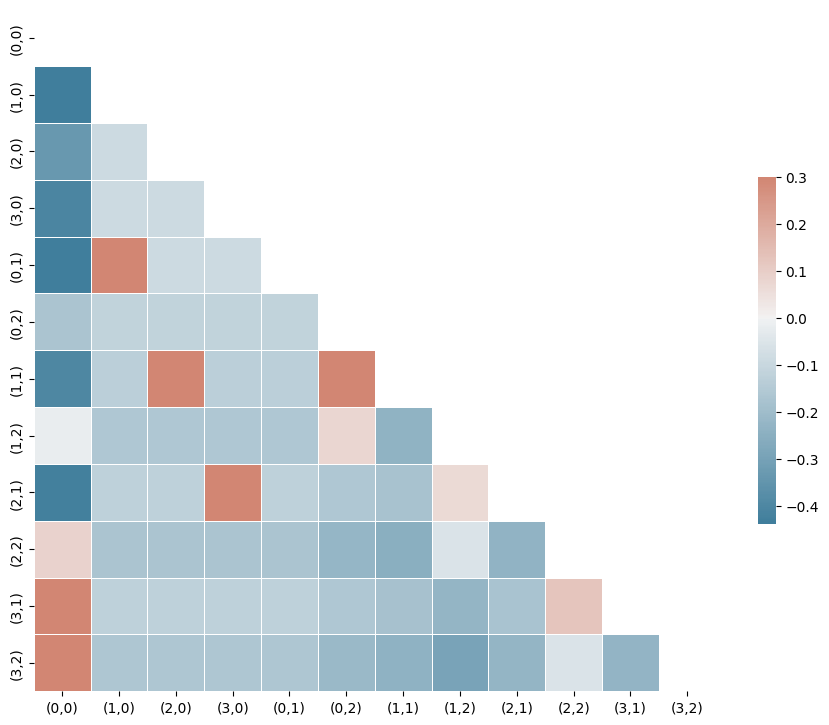

In [68]:
m = pd.DataFrame(m)
non_terminal_state_labels = ["(0,0)","(1,0)","(2,0)","(3,0)","(0,1)","(0,2)","(1,1)","(1,2)","(2,1)","(2,2)","(3,1)","(3,2)"]
m = m.rename(columns={0:"(0,0)",
                  1:"(1,0)",
                  2:"(2,0)",
                  3:"(3,0)",
                  4:"(0,1)",
                  5:"(0,2)",
                  6:"(1,1)",
                  7:"(1,2)",
                  8:"(2,1)",
                  9:"(2,2)",
                  10:"(3,1)",
                  11:"(3,2)"})
corr = m.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})